In [ ]:
!gdown --id 1-LIYJN6frwbjjC8K3zv57fLFyhAAxlhK

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-LIYJN6frwbjjC8K3zv57fLFyhAAxlhK
To: /content/house-prices-advanced-regression-techniques.zip
100% 204k/204k [00:00<00:00, 99.3MB/s]


In [ ]:
!unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data_description.txt    
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [ ]:
ls

data_description.txt                             sample_submission.csv
house-prices-advanced-regression-techniques.zip  test.csv
sample_data/                                     train.csv


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [ ]:
data = pd.read_csv('train.csv')

# Discretize target variable
data = data.drop("Id", axis=1)
data['SalePrice'] = pd.qcut(data['SalePrice'], q=3, labels=["low", "medium", "high"])

label_encoder = LabelEncoder()
target_names = ["low", "medium", "high"]

data['SalePrice'] = label_encoder.fit_transform(data['SalePrice'])

X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

# Fill missing values
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Encode categorical features
for column in X.columns:
    if X[column].dtype == object:
        encoder = LabelEncoder()
        X[column] = encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
rf = RandomForestClassifier(random_state=42)

rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         low       0.92      0.87      0.90        94
      medium       0.83      0.92      0.87       110
        high       0.77      0.70      0.73        88

    accuracy                           0.84       292
   macro avg       0.84      0.83      0.83       292
weighted avg       0.84      0.84      0.84       292



<ipython-input-7-1c885cab10de>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  featuresCorr = data.corr()


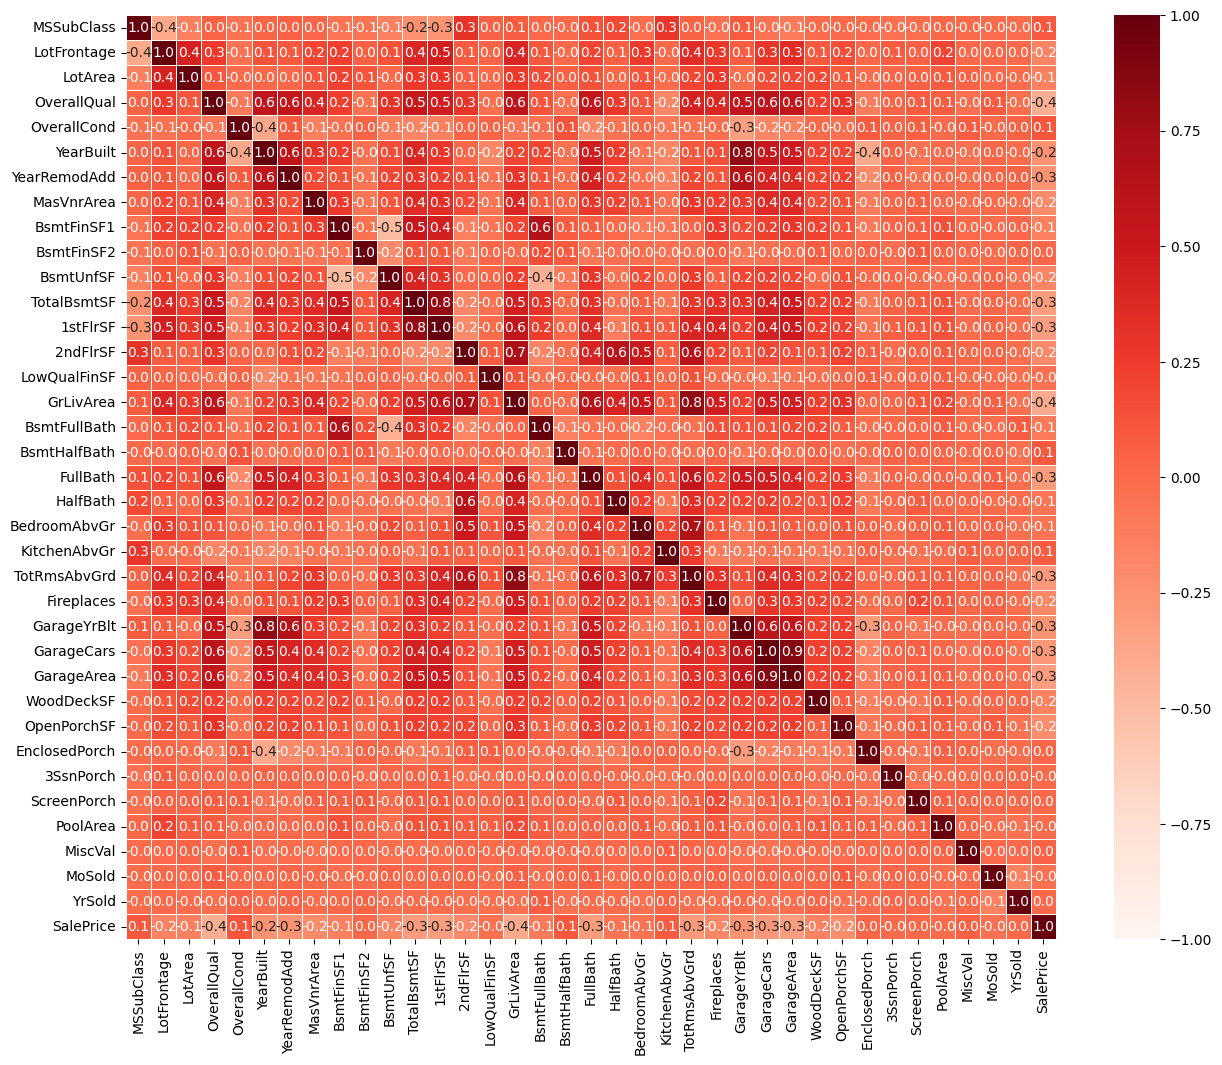

In [ ]:
featuresCorr = data.corr()
plt.figure(figsize=(15,12))
sns.heatmap(featuresCorr, annot=True, cmap=plt.cm.Reds, vmax=1, vmin=-1, fmt=".1f", linewidth=0.5)
plt.show()

In [ ]:
# 相關係數 > 0.3 or < -0.3 的特徵
targetCorr = abs(featuresCorr['SalePrice'])
targetCorr = targetCorr.drop('SalePrice')
selectedFeatures = targetCorr[targetCorr>0.3]
print(f"Number of selected features: {len(selectedFeatures)} \n\nHighly relative feature list:\n{selectedFeatures}")

Number of selected features: 6 

Highly relative feature list:
OverallQual    0.420382
TotalBsmtSF    0.312407
1stFlrSF       0.319379
GrLivArea      0.395811
FullBath       0.312247
GarageArea     0.318523
Name: SalePrice, dtype: float64


In [ ]:
corr_select_rf = RandomForestClassifier(random_state=42)
corr_select_rf.fit(X_train[list(selectedFeatures.keys())], y_train)

corr_select_pred = corr_select_rf.predict(X_test[list(selectedFeatures.keys())])
print(classification_report(y_true=y_test, y_pred=corr_select_pred, target_names=target_names))

              precision    recall  f1-score   support

         low       0.88      0.85      0.86        94
      medium       0.86      0.85      0.85       110
        high       0.70      0.74      0.72        88

    accuracy                           0.82       292
   macro avg       0.81      0.81      0.81       292
weighted avg       0.82      0.82      0.82       292



In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

chi2, p_value = chi2(X_train, y_train)

In [ ]:
chi_df = pd.DataFrame({'chi-squares test': chi2, 'p-value':p_value})
chi_df['p-value'] = chi_df['p-value'].round(4)
chi_df = chi_df.sort_values('chi-squares test', ascending=False)
chi_df.style.background_gradient(cmap='Blues')

,chi-squares test,p-value
3,586385.699282,0.000000
45,79338.177211,0.000000
43,56067.925113,0.000000
37,55372.820251,0.000000
25,38819.947011,0.000000
42,37370.481130,0.000000
61,37127.897573,0.000000
33,34216.682979,0.000000
36,25456.479668,0.000000
65,19550.713688,0.000000


In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

chi2Filter = SelectKBest(chi2, k=20)
chi2Filter.fit(X_train, y_train)

# 選取完的 top 20 特徵
X_train_new = chi2Filter.transform(X_train)
X_test_new = chi2Filter.transform(X_test)

In [ ]:
print('train shape:', X_train_new.shape)
print('test shape:', X_test_new.shape)

train shape: (1168, 20)
test shape: (292, 20)


In [ ]:
chi2Filter.get_feature_names_out()

array(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'GarageType', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'PoolArea', 'MiscVal'], dtype=object)

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_new, y_train)

chi2_select_pred_20 = rf.predict(X_test_new)
print(classification_report(y_true=y_test, y_pred=chi2_select_pred_20))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90        94
           1       0.84      0.88      0.86       110
           2       0.74      0.73      0.73        88

    accuracy                           0.83       292
   macro avg       0.83      0.83      0.83       292
weighted avg       0.83      0.83      0.83       292



In [ ]:
# from sklearn.feature_selection import SequentialFeatureSelector

# # 需要基於一個分類器
# rf = RandomForestClassifier(random_state=42)
# forward_select_rf = SequentialFeatureSelector(rf, scoring='recall', n_features_to_select=10)
# forward_select_rf.fit(X_train, y_train)

In [ ]:
df = pd.read_csv('train.csv')

# Discretize target variable
df = df.drop("Id", axis=1)


X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Fill missing values
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Encode categorical features
for column in X.columns:
    if X[column].dtype == object:
        encoder = LabelEncoder()
        X[column] = encoder.fit_transform(X[column])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# 建立線性回歸模型
regressor = LinearRegression()

# 使用訓練數據集訓練模型
regressor.fit(X_train, y_train)

# 進行預測
y_pred = regressor.predict(X_test)


# 評估模型
print('模型性能:')
print('平均絕對誤差:', metrics.mean_absolute_error(y_test, y_pred))
print('均方誤差:', metrics.mean_squared_error(y_test, y_pred))
print('均方根誤差:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

模型參數:
斜率 (權重): [-1.32668386e+02 -2.23165131e+03 -2.50666513e+02  3.73651202e-01
  1.97318204e+04  4.42357527e+03 -1.10615380e+03  3.12710448e+03
 -5.46412955e+04  1.77726714e+00  1.07352717e+04  4.26843484e+02
 -7.41929160e+02 -1.09202547e+04 -2.39833204e+03 -9.75019710e+02
  1.06950904e+04  4.97912881e+03  2.04903134e+02  5.46821554e+01
  2.49428275e+03  5.73413497e+03 -1.54835313e+03  8.53430127e+02
  3.59647384e+03  2.63198130e+01 -8.31294004e+03  2.02848232e+02
  1.06995132e+03 -9.92973725e+03  3.46820529e+03 -3.58278056e+03
 -4.49674670e+02  2.05171188e+00  9.85148135e+02  3.44922959e+00
 -5.16852569e+00  3.32415734e-01 -7.71024040e+02 -4.77666462e+02
 -1.77258073e+02 -4.68136794e+02  2.55568137e+01  1.76201553e+01
 -1.91180845e+01  2.40588846e+01  7.29409698e+03 -3.70309368e+03
  2.40397581e+03 -5.69734517e+02 -1.84189726e+03 -1.17441597e+04
 -9.38037369e+03  3.71265649e+03  4.73689594e+03  4.08928995e+03
 -1.01544487e+03  3.90389056e+01 -1.50474595e+01  1.12330400e+03
  1.188600

<ipython-input-18-81c67f321e40>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  featuresCorr = df.corr()


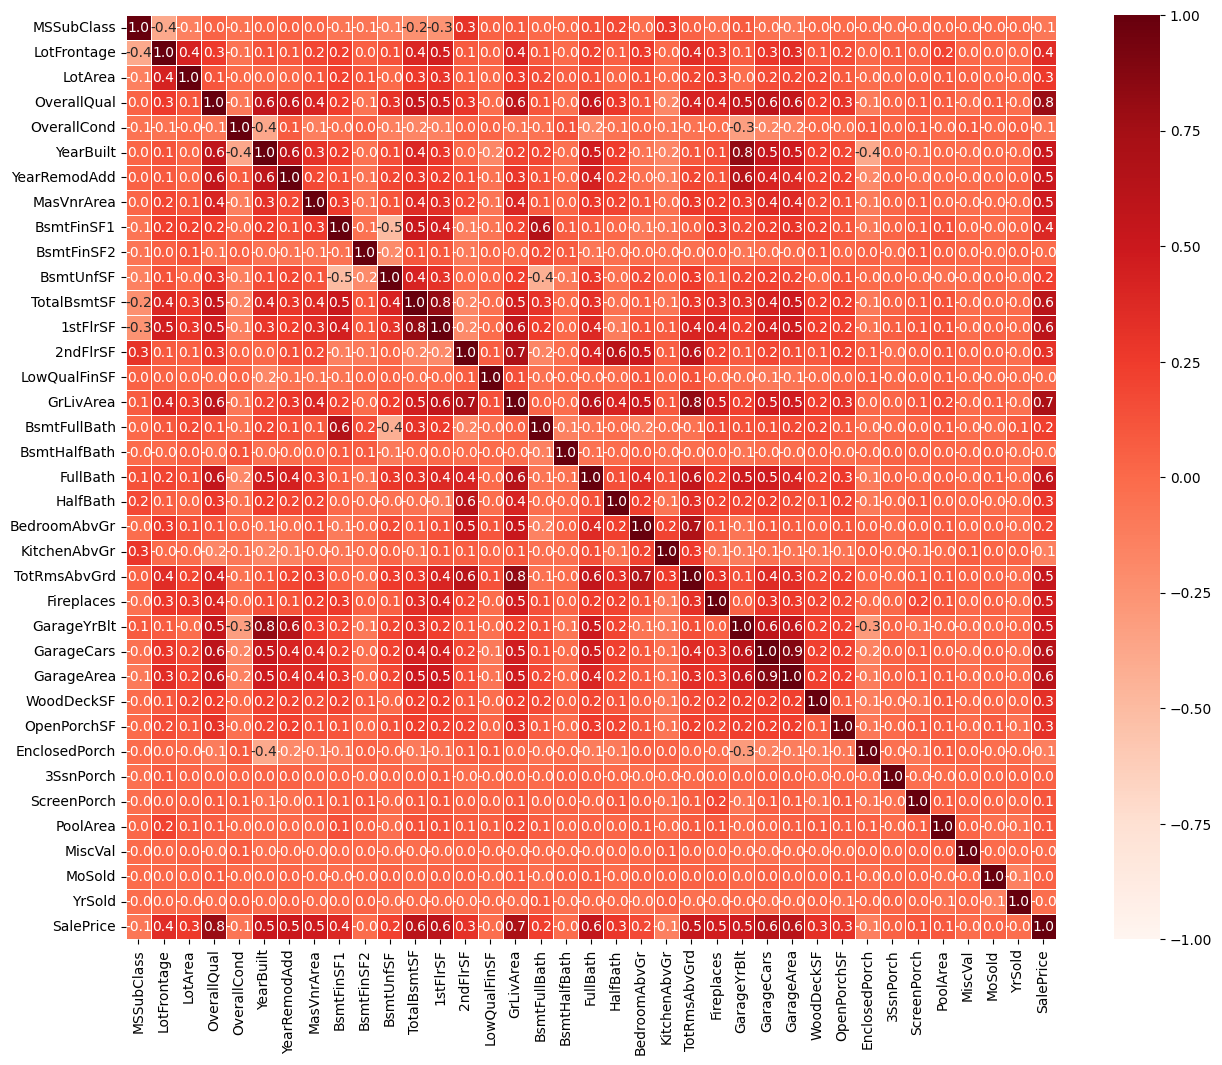

In [ ]:
featuresCorr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(featuresCorr, annot=True, cmap=plt.cm.Reds, vmax=1, vmin=-1, fmt=".1f", linewidth=0.5)
plt.show()

In [ ]:
# 相關係數 > 0.3 or < -0.3 的特徵
targetCorr = abs(featuresCorr['SalePrice'])
targetCorr = targetCorr.drop('SalePrice')
selectedFeatures = targetCorr[targetCorr>0.3]
print(f"Number of selected features: {len(selectedFeatures)} \n\nHighly relative feature list:\n{selectedFeatures}")

Number of selected features: 18 

Highly relative feature list:
LotFrontage     0.351799
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.477493
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageYrBlt     0.486362
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
Name: SalePrice, dtype: float64
